In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## Biassay model

Bioassay model. In this exercise, you will use a dose-response relation model that is used in Section 3.7 of the course book and in the chapter reading instructions. The used likelihood is the same, but instead of uniform priors, we will use a bivariate normal distribution as the joint prior distribution of the parameters α and β.

### a) 

In the prior distribution for (α, β), the marginal distributions are α ∼ N (0, 2^2) and β ∼ N (10, 10^2), and the correlation between them is corr(α, β) = 0.6. Report the mean (vector of two values) and covariance (two by two matrix) of the bivariate normal distribution. 

Hint! The mean and covariance of the bivariate normal distribution are a length 2 vector and a 2 × 2 matrix. The elements of the covariance matrix can be computed using the relation of correlation and covariance.

In [2]:
#prior
x = np.linspace(-10, 20, 1000).reshape(-1)
x.shape

(1000,)

In [3]:
#mean vector is 
means=[0, 10]

In [4]:
cov=0.6*(2**2)*(10**2)
cov_mat=[[2**2, 0.6*10*2],
        [0.6*2*10, 10**2]]
cov_mat

[[4, 12.0], [12.0, 100]]

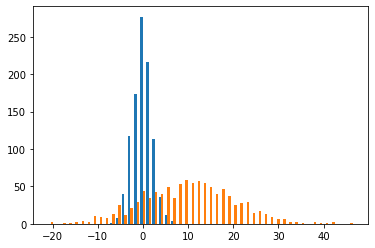

In [5]:
y_samp=stats.multivariate_normal.rvs(mean=[0, 10], cov=cov_mat, size=1000)
_=plt.hist(y_samp, bins=50)

In [6]:
y_samp

array([[ -2.63638148, -12.86972913],
       [  1.84880896,  21.54406519],
       [ -0.16737419,   1.94944763],
       ...,
       [ -1.52315807,  28.78620642],
       [ -0.39766116,  16.27886189],
       [ -0.33155444,   2.29207283]])

Text(0, 0.5, 'beta')

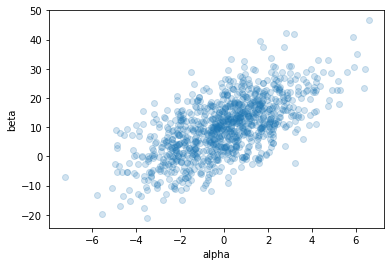

In [7]:
plt.scatter(y_samp[:,0], y_samp[:,1], alpha=0.2)
plt.xlabel('alpha')
plt.ylabel('beta')

### b)

You are given 4000 independent draws from the posterior distribution of the model. Load the draws with data ("bioassay_posterior"). Report the mean as well as 5 % and 95 % quantiles separately for both α and β. Report also the Monte Carlo standard errors (MCSEs) for the mean and quantile estimates. Report as many digits for the mean and quantiles as the MCSEs allow. In other words, leave out digits where MCSE is nonzero (Example: if posterior mean is 2.345678 and MCSE is 0.0012345, report two digits after the decimal sign, taking into account the usual rounding rule, so you would report 2.35. Further digits do not contain useful information due to the Monte Carlo uncertainty.). Explain in words what does Monte Carlo standard error mean and how you decided the number of digits to show. 

Note! The answer is graded as correct only if the number of digits reported is correct! The number of signicant digits can be different for the mean and quantile estimates. In some other cases, the number of digits reported can be less than MCSE allows for practical reasons.

Hint! Quantiles can be computed with the quantile function. With S draws, the MCSE for E[θ] is √Var[θ]/S. MCSE for the quantile estimates can be computed with the mcse_quantile function from the aaltobda package.

In [8]:
df_posterior=pd.read_csv('data/bioassay_posterior.txt',sep='\t', header=None)
df_posterior.columns=['alpha', 'beta']
df_posterior.shape

(4000, 2)

In [9]:
df_posterior.head()

,alpha,beta
0,-0.020506,10.032841
1,1.217385,4.504546
2,3.048294,16.239424
3,1.322728,4.924268
4,1.362748,12.880561


In [10]:
df_posterior.mean(axis=0).round(1)

alpha     1.0
beta     10.6
dtype: float64

<AxesSubplot:>

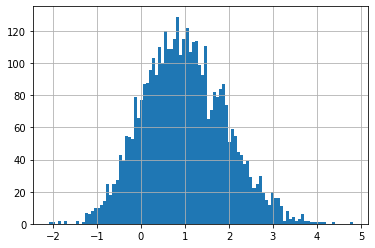

In [11]:
df_posterior.alpha.hist(bins=100)

<AxesSubplot:>

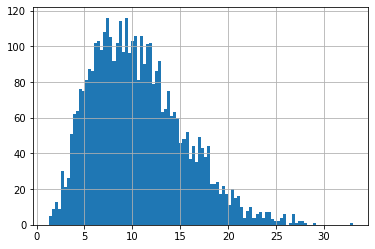

In [12]:
df_posterior.beta.hist(bins=100)

<AxesSubplot:xlabel='alpha', ylabel='beta'>

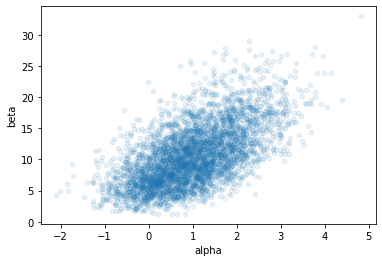

In [13]:
df_posterior.plot.scatter(x='alpha', y='beta', alpha=0.1)

In [14]:
#MCSE for alpha
np.round(np.std(df_posterior.alpha)/np.sqrt(df_posterior.shape[0]), 4)

0.0148

In [15]:
#MCSE for beta
np.round(np.std(df_posterior.beta)/np.sqrt(df_posterior.shape[0]), 4)

0.0756

In [16]:
def mcse_quantile(x, q):
    #source: https://github.com/avehtari/BDA_course_Aalto/blob/master/rpackage/R/mcse_quantile.R
    s=len(x)
    # these are the same as pnorm(c(-1,1)) and these are passed through
    # a non-linear mapping
    #obtained: stats.norm.cdf(-1) and stats.norm.cdf(1)
    p = [0.1586553, 0.8413447]
    a = stats.beta.ppf(p, s * q + 1, s * (1 - q) + 1)
    sx = np.sort(x.values.reshape(-1))
    th1=sx[int(max(np.floor(a[0] * s)-1, 1))]
    th2 = sx[int(min(np.ceil(a[1] * s)-1, s))]
    # if the mapping from p to th would be linear, this would give
    # exact MCSE, but even with non-linear mapping this is a good approximation
    mcse = (th2 - th1) / 2
    return mcse

In [17]:
mcse_quantile(df_posterior.alpha, 0.05)

0.026004115975011483

In [18]:
mcse_quantile(df_posterior.alpha, 0.95)

0.04206341679185521

In [19]:
mcse_quantile(df_posterior.beta, 0.05)

0.0704312509185201

In [20]:
mcse_quantile(df_posterior.beta, 0.95)

0.24121288770735028

In [21]:
#quantiles 5%
np.quantile(df_posterior.alpha, 0.05).round(1), np.quantile(df_posterior.beta, 0.05).round(1)

(-0.5, 4.0)

In [22]:
#quantiles 95%
np.quantile(df_posterior.alpha, 0.95).round(1), np.quantile(df_posterior.beta, 0.95).round(0)

(2.6, 19.0)

### Importance sampling. Now we discard our posterior draws and switch to importance sampling.

### c)

Implement a function for computing the log importance ratios (log importance weights) when the importance sampling target distribution is the posterior distribution, and the proposal distribution is the prior distribution from a). Below is a test example, the functions can also be tested with markmyassignment. Explain in words why it's better to compute log ratios instead of ratios.

- Note! The values below are only a test case. In this c) part, you only need to report the source code of your function, as it will be needed in later parts. 

- Hints! Use the function rmvnorm from the aaltobda package for sampling. Non-log importance ratios are given by equation (10.3) in the course book. The fact that our proposal distribution is the same as the prior distribution makes this task easier. The logarithm of the likelihood can be computed with the bioassaylp function from the aaltobda package. The data required for the likelihood can be loaded with data("bioassay").

alpha <- c(1.896, -3.6, 0.374, 0.964, -3.123, -1.581)

beta <- c(24.76, 20.04, 6.15, 18.65, 8.16, 17.4) 

round(log_importance_weights(alpha, beta),2) 

[1] -8.95 -23.47 -6.02 -8.13 -16.61 -14.57

In [23]:
#bioassay data
df_data=pd.read_csv('data/bioassay.csv')
df_data.shape

(4, 3)

In [24]:
df_data

,x,n,y
0,-0.86,5,0
1,-0.30,5,1
2,-0.05,5,3
3,0.73,5,5


In [25]:
#test data
alpha=np.array([1.896, -3.6, 0.374, 0.964, -3.123, -1.581])
beta=np.array([24.76, 20.04, 6.15, 18.65, 8.16, 17.4])

In [26]:
def bioassaylp(alpha, beta, x, y, n):
    """#' Unnormalized log-posterior for bioassay, assuming uniform prior
    #' @param alpha intercept parameter in the dose-response model (vector or single number)
    #' @param beta slope parameter in the dose-response model (vector or single number)
    #' @param x vector of doses for each observation
    #' @param y vector of number of deaths for each observation
    #' @param n vector of number of animals for each observation
    Source: https://github.com/avehtari/BDA_course_Aalto/blob/master/rpackage/R/bioassaylp.R"""
    t = alpha.reshape(-1,1) + np.outer(beta, x)
    et = np.exp(t)
    z = et/(1 + et)
    # ensure that log(z) and log(1-z) are computable
    eps = 1e-12
    z[z>(1-eps)] = (1-eps)
    z[z<eps] = eps
    lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)
    return lp

def log_importance_weights(alpha, beta, x, y, n):
    lp=bioassaylp(alpha, beta, x, y, n)
    return lp

In [27]:
log_importance_weights(alpha, beta, df_data.x, df_data.y, df_data.n).round(2)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


array([ -8.95, -23.47,  -6.02,  -8.13, -16.61, -14.57])

### d)

Implement a function for computing normalized importance ratios from the unnormalized log ratios in c). In other words, exponentiate the log ratios and scale them such that they sum to one. Explain in words what is the effect of exponentiating and scaling so that sum is one. Below is a test example, the functions can also be tested with markmyassignment. 

Note! The values below are only a test case. In this d) part, you only need to report the source code of your function, as it will be needed in later parts.

In [28]:
def normalized_importance_weights(alpha, beta, x, y, n):
    lp=log_importance_weights(alpha, beta, x, y, n)
    return np.exp(lp)/np.exp(lp).sum()

In [29]:
normalized_importance_weights(alpha, beta, df_data.x, df_data.y, df_data.n).round(3)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


array([0.045, 0.   , 0.852, 0.103, 0.   , 0.   ])

### e)

Sample 4000 draws of α and β from the prior distribution from a). Compute and plot a histogram of the 4000 normalized importance ratios. Use the functions you implemented in c) and d).

In [30]:
y_samp=stats.multivariate_normal.rvs(mean=[0, 10], cov=cov_mat, size=4000)

In [31]:
imp_ratio=normalized_importance_weights(y_samp[:,0], y_samp[:,1], df_data.x, df_data.y, df_data.n)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


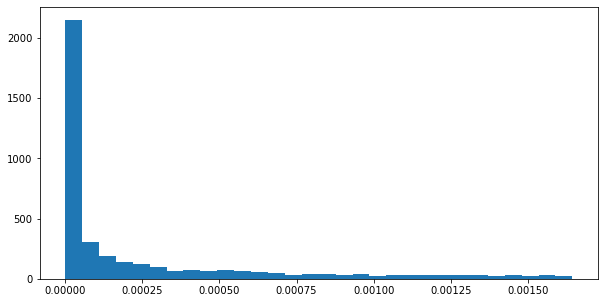

In [32]:
fig, ax =plt.subplots(figsize=(10,5))
_=plt.hist(imp_ratio, bins=30)

### f)

Using the importance ratios, compute the importance sampling effective sample size Seff and report it. 

Note! The values below are only a test case, you need to use 4000 draws for alpha and beta in the final report.

Hint! Equation (10.4) in the course book. 

Note! BDA3 1st (2013) and 2nd (2014) printing have an error for  ̃ w(θs) used in the effective sample size equation (10.4). The normalized weights equation should not have the multiplier S (the normalized weights should sum to one). Errata for the book http://www.stat.columbia.edu/~gelman/book/errata_bda3.txt. The later printings, the online version, and the slides have the correct equation.

In [33]:
def S_eff(alpha, beta, x, y, n):
    imp_ratio=normalized_importance_weights(alpha, beta, x, y, n)
    return 1/np.sum(imp_ratio**2)

S_eff(alpha, beta, df_data.x, df_data.y, df_data.n).round(3)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


1.354

In [34]:
#prior draws
S_eff(y_samp[:,0], y_samp[:,1], df_data.x, df_data.y, df_data.n).round(3)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


1119.873

In [35]:
#bioassay data
S_eff(np.array(df_posterior.alpha.tolist()), np.array(df_posterior.beta.tolist()), df_data.x, df_data.y, df_data.n).round(3)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


3066.061

### g)

Explain in your own words what the importance sampling effective sample size represents. Also explain how the effective sample size is seen in the histogram of the weights that you plotted in e).

The importance sampling effective sample size indicates how well the samples from the importance sampling cover the density of the target distribution $q(\theta|y)$.
Ideally, the weights are uniform, resulting in a $S_\text{eff}$ near the true number of draws (i.e. 4000 in this case).
If there are some samples with very high importance, then $S_\text{eff}$ gets smaller to indicate that the sampling did accurately cover the target distribution.

The $S_\text{eff}$ for the prior draws is calculated above.
We can see that even though there were 4000 draws, the effective sampling size is about 1100.
This means that the prior samples do no accurately sample from the target distribution.
We can see this in the histogram with most importance weights near 0 and a thick tail of higher values.
This is also shown in the plot below of the prior samples colored by their importance ratios.
There is a density of higher importance ratios in one region of the samples, likely indicating where there is a lot of posterior density for the model.

In [36]:
df_prior_draws=pd.DataFrame(y_samp)
df_prior_draws.columns=['alpha', 'beta']
df_prior_draws['imp_ratio']=imp_ratio
df_prior_draws.head()

,alpha,beta,imp_ratio
0,0.814211,19.853679,0.000095
1,3.805136,19.289152,0.000111
2,1.365418,11.274604,0.001339
3,0.787294,18.722183,0.000131
4,2.504298,12.006757,0.000522


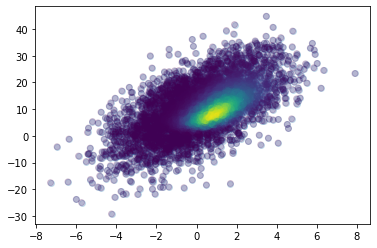

In [37]:
plt.scatter(df_prior_draws.alpha, df_prior_draws.beta, alpha=0.2)
plt.scatter(df_prior_draws.alpha, df_prior_draws.beta, alpha=0.2, c=df_prior_draws.imp_ratio)

### h)

Implement a function for computing the posterior mean using importance sampling, and compute the mean using your 4000 draws. Explain in your own words the computation for importance sampling. Below is an example how the function would work with the example values for alpha and beta above. Report the means for alpha and beta, and also the Monte Carlo standard errors (MCSEs) for the mean estimates. Report the number of digits for the means based on the MCSEs. 

Note! The values below are only a test case, you need to use 4000 draws for alpha and beta in the final report. 

Hint! Use the same equation for the MCSE of E[θ] as earlier (√Var[θ]/S), but now replace S with Sef. To compute Var[θ] with importance sampling, use the identity Var[θ] = E[θ^2] − E[θ]^2.

In [38]:
def posterior_mean(alpha, beta, x, y, n):
    ws=log_importance_weights(alpha, beta, x, y, n)
    ws=np.exp(ws)
    #deal with nans
    index_not_null=~pd.isnull(ws)
    ws=ws[index_not_null]
    alpha=alpha[index_not_null]
    beta=beta[index_not_null]
    
    df_theta=pd.DataFrame({'alpha':alpha,
                       'beta':beta})
    mu_theta_post=df_theta.apply(lambda x: np.sum(x*ws)/np.sum(ws), axis=0)
    return mu_theta_post

In [39]:
mu_theta_post=posterior_mean(alpha, beta, df_data.x, df_data.y, df_data.n)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)


In [40]:
mu_theta_post.round(3)

alpha    0.503
beta     8.275
dtype: float64

The posterior mean (expectation) of $\theta = (\alpha, \beta)$ can be computed using importance sampling using the following equation (eq. 10.3 in *BDA3*):

$$
\text{E}(h(\theta|y)) = \frac{\frac{1}{S} \sum^S h(\theta^s) w(\theta^s)}{\frac{1}{S} \sum^S w(\theta^s)} \\
w(\theta^s) = \frac{q(\theta^s|y)}{g(\theta^s)}
$$

where $w(\theta^s)$ is the importance weight calculated as the quotient of the target distribution $q$ and the proposal distribution $g$.
The importance weights are calculated in `log_importance_weights()` in question c).

In this case, $h(\theta|y)$ is the posterior distribution of $\theta$ and $\text{E}(h(\theta|y))$ is the mean of the posterior distribution of $\theta$.
$h(\theta)$ is the prior distribution.
Thus, the algorithm is weight prior draws by their importance weight.

Importance sampling is really just a method for weighting possible values of $\theta$ by their importance ratio.
In this case, because we used the prior distribution at the proposal distribution, the importance ratio is the probability of $\theta$ under the unnormalized posterior distribution.
Thus, this procedure weights possible values of $\theta$ by how likely they are given the posterior distribution.

In [41]:
#MCSE calculation
prior_a=y_samp[:,0]
prior_b=y_samp[:,1]

post_means=posterior_mean(prior_a, prior_b, df_data.x, df_data.y, df_data.n)
post_means_sqr=posterior_mean(prior_a**2, prior_b**2, df_data.x, df_data.y, df_data.n)
seff=S_eff(prior_a, prior_b, df_data.x, df_data.y, df_data.n)
var= np.abs(post_means_sqr - (post_means**2))
mcse=np.sqrt(var / seff)
mcse

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)
C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:10: RuntimeWarning: overflow encountered in exp
  et = np.exp(t)
C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:11: RuntimeWarning: invalid value encountered in true_divide
  z = et/(1 + et)
C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_25020\2946651631.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lp = ((np.log(z).T*y[:,None]).T+ (np.log(1 - z).T*(n-y)[:,None]).T).sum(axis=1)
C:\Users\RistoHinno\AppData\Local\Temp\ipyke

alpha    0.008449
beta     0.299747
dtype: float64

In [42]:
#rounding based on MCSE
#alpha pos mean
mu_theta_post.alpha.round(0)

1.0

In [43]:
#beta post mean
mu_theta_post.beta.round(0)

8.0

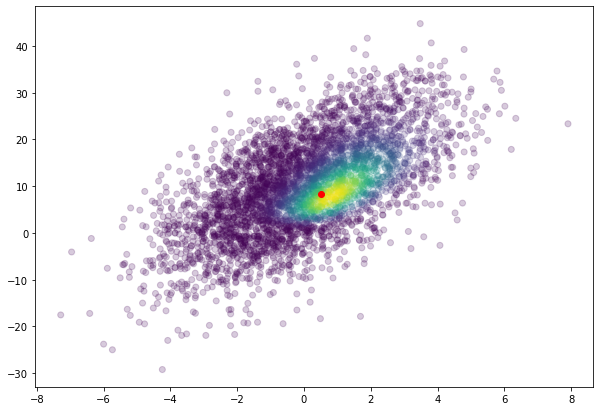

In [44]:
fig, ax=plt.subplots(figsize=(10,7))
plt.scatter(df_prior_draws.alpha, df_prior_draws.beta, alpha=0.01)
plt.scatter(df_prior_draws.alpha, df_prior_draws.beta, alpha=0.2, c=df_prior_draws.imp_ratio)
plt.scatter(mu_theta_post.alpha, mu_theta_post.beta, c='red')